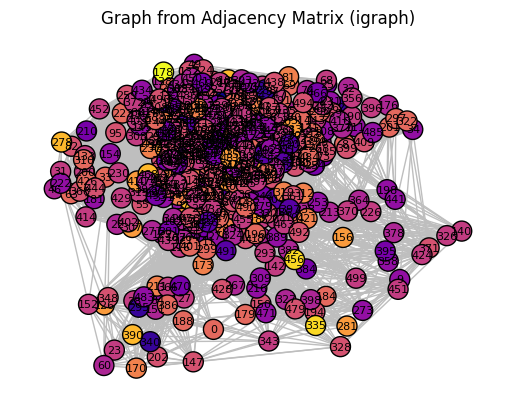

In [1]:
import numpy as np

from framework.SMS import import_dataset_fromSMS, plot_graph_from_adjacency_matrix

datasetSMS = import_dataset_fromSMS("data/SMS/wavy500/")

sim = list(datasetSMS.keys())[0]
mat = datasetSMS[sim]['adjacency_matrix']
num_nodes = mat.shape[0]
p_vectors_array = datasetSMS[sim]['p_array']
dimP = p_vectors_array.shape[1]


plot_graph_from_adjacency_matrix(mat, node_color_scalars=np.sum(p_vectors_array, axis=1), cmap='plasma')


In [2]:
def read_matrix_from_csv_loadtxt(filepath, delimiter=','):
  """
  Reads a NumPy matrix from a CSV file using np.loadtxt().

  Args:
    filepath (str): The path to the CSV file.
    delimiter (str): The character separating values in the CSV file (default is comma).

  Returns:
    numpy.ndarray: The matrix read from the CSV file.
  """
  try:
    matrix = np.loadtxt(filepath, delimiter=delimiter)
    print(f"Successfully loaded matrix from {filepath} using np.loadtxt().")
    return matrix
  except FileNotFoundError:
    print(f"Error: The file '{filepath}' was not found.")
    return None
  except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    return None

In [3]:
path = "data/SMS/wavy500/sim_" + str(sim) + "/wavy_p_matrix.csv"
p_vectors_array = read_matrix_from_csv_loadtxt(path)
dimP = p_vectors_array.shape[1]
for x in datasetSMS.values():
    x["p_array"]=p_vectors_array

Successfully loaded matrix from data/SMS/wavy500/sim_8736/wavy_p_matrix.csv using np.loadtxt().


In [4]:
from framework.trainFct import *
from torch_geometric.data import Data, DataLoader
from framework.visuals import *

latent_dim = 2
input_dim = dimP
batch_size = 16

encoder_hidden_dims=[128, 64, 32]
adj_decoder_hidden_dims=[64, 64, 32]
node_decoder_hidden_dims=[64, 64, 32]
gcn_layers=3
fc_layers=2

dataset = []
for x in datasetSMS.values():
    # Create PyG data object
    data = Data(x=torch.tensor(x["p_array"], dtype=torch.float), 
                edge_index=adj_matrix_to_edge_index(x["adjacency_matrix"])[0], 
                edge_labels=adj_matrix_to_edge_index(x["adjacency_matrix"])[1],
                adjacency_matrix=torch.tensor(x["adjacency_matrix"]))
    dataset.append(data)

# Select a single graph to train on
single_graph = dataset[0]

# Wrap in list for compatibility with DataLoader-like expectations
single_graph_list = [single_graph]


/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

In [3]:
# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = create_graphvae_model(
    input_dim=input_dim,
    latent_dim=latent_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    adj_decoder_hidden_dims=adj_decoder_hidden_dims,
    node_decoder_hidden_dims=node_decoder_hidden_dims,
    gcn_layers=gcn_layers,
    fc_layers=fc_layers,
    kl_annealing=True,
    anneal_steps=1000,
    anneal_end=100
)

history = train_model(
    model=model,
    data_loader=data_loader,
    num_epochs=1000,
    lr=0.001,
    verbose=False,
    decoder_weights={"adj_decoder": 100000, "node_attr_decoder":100000}
)

visualize_training(history)
visualize_graph_reconstruction(model, dataset[0])
visualize_node_features_reconstruction(model, dataset[0])
interpolate_in_latent_space(model, dataset[0], dataset[5])

/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


KeyboardInterrupt: 

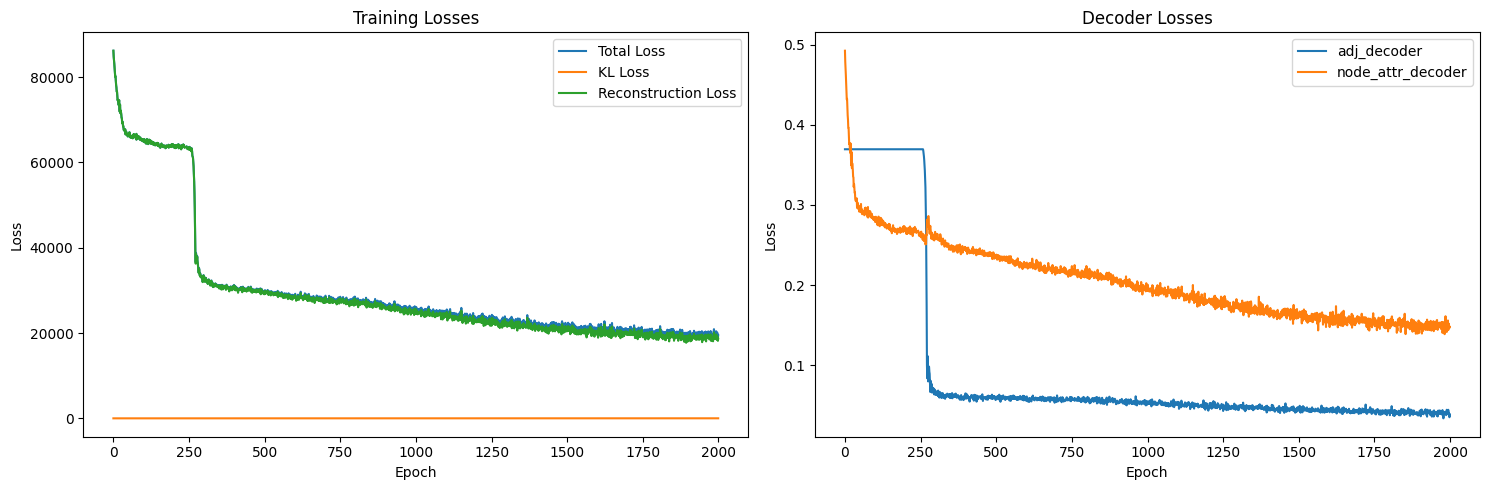

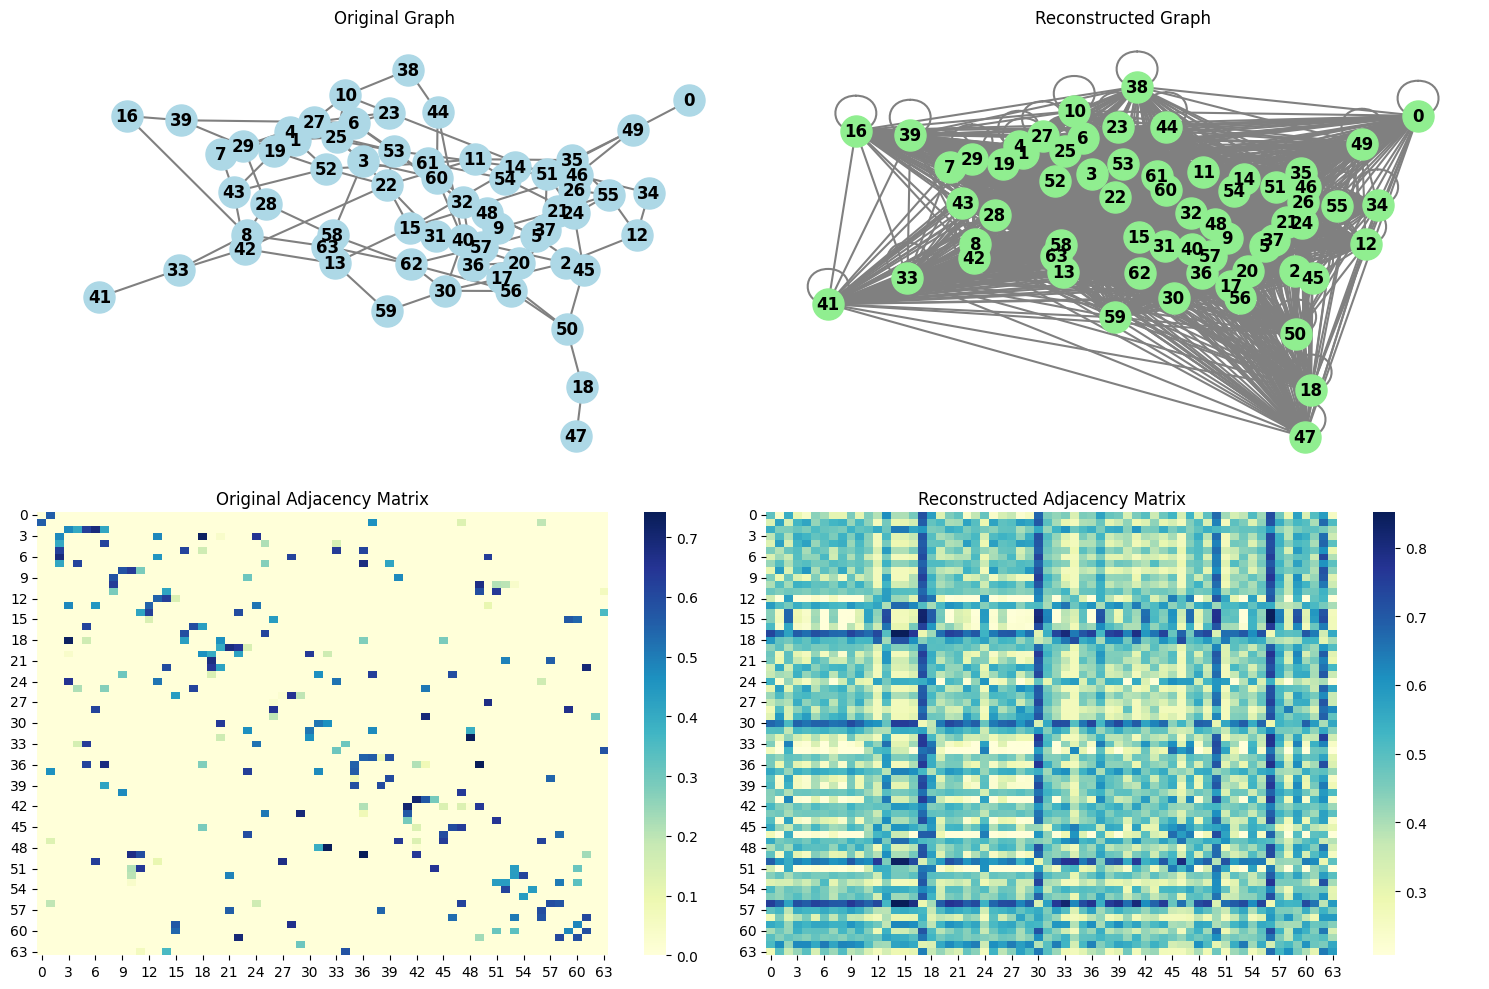

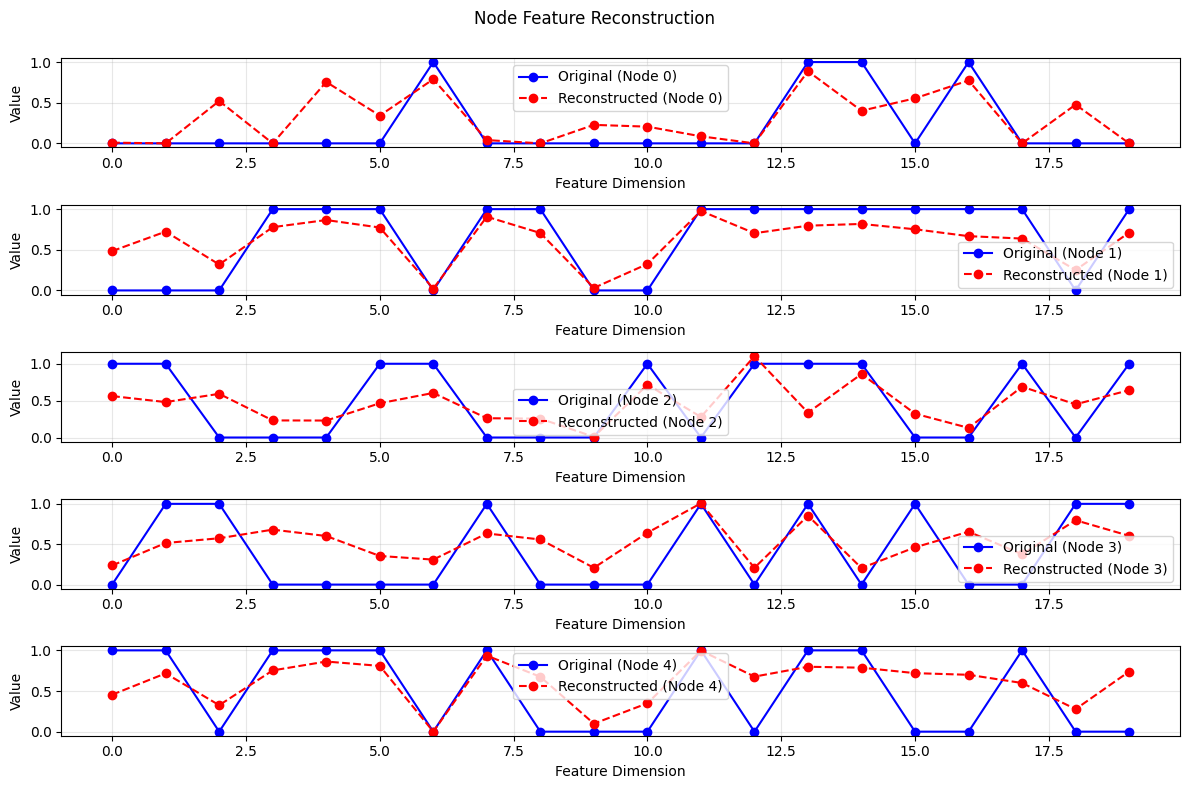

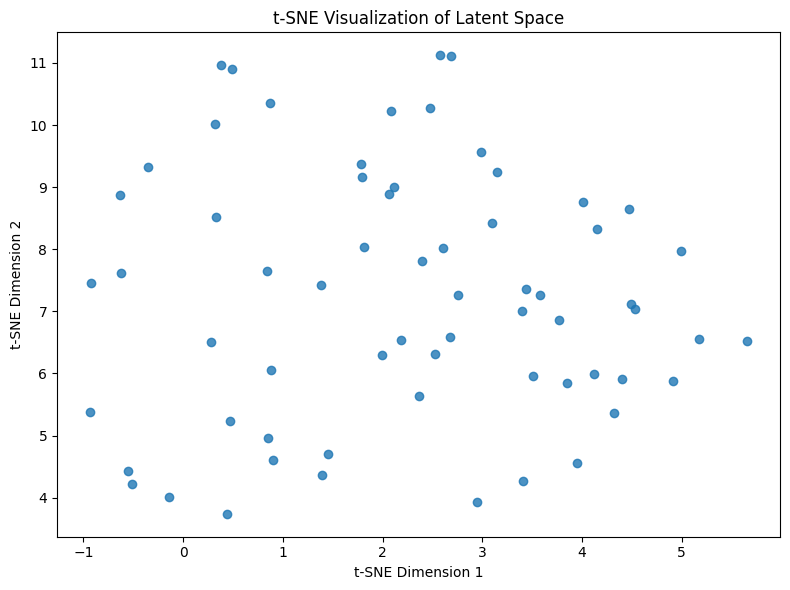

In [ ]:
model = create_graphvae_model(
    input_dim=input_dim,
    latent_dim=latent_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    adj_decoder_hidden_dims=adj_decoder_hidden_dims,
    node_decoder_hidden_dims=node_decoder_hidden_dims,
    gcn_layers=gcn_layers,
    fc_layers=fc_layers,
    kl_annealing=True,
    anneal_steps=1000,
    anneal_end=100
)

history = train_model(
    model=model,
    data_loader=single_graph_list,
    num_epochs=2000,
    lr=0.001,
    verbose=False,
    decoder_weights={"adj_decoder": 100000, "node_attr_decoder":100000}
)

# Visualizations
visualize_training(history)
visualize_graph_reconstruction(model, single_graph)
visualize_node_features_reconstruction(model, single_graph, sample_features=dimP)
visualize_latent_space(model, [single_graph])



In [6]:
from utils.manifolds.visuals import *
from utils.manifolds.core import *

def plot_curvature(model_phase1, single_graph):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_phase1.eval()

    with torch.no_grad():
        x = single_graph.x.to(device)
        edge_index = single_graph.edge_index.to(device)
        latent_mu = model_phase1.encode(x, edge_index)
        recon = model_phase1.forward(x,edge_index)

    def local_decoder_point_metric(z):
        """
        Wrapper to compute the Riemannian metric from the jacobian matrix
        z: numpy array with shape (n,)
        
        Returns an (n x n) metric tensor.
        """
        G = None
        try:
            J = model_phase1.compute_jacobian(torch.unsqueeze(torch.tensor(z, dtype=torch.float),0), "node_attr_decoder", 0)
            G = np.matmul(J.T, J)
                
        except Exception as e:
            print(f"Error at grid point ({z}): {e}")
        return G.numpy()

    #n_dimensions = 2
    #data = latent_mu.numpy()[:10,:]
    #print("Computing distance matrix...")
    #dist = create_riemannian_distance_matrix(data, metric)
    #print("Visualizing...")
    #visualize_manifold_embedding(data,dist )
    z_l = latent_mu[0].numpy()
    curvature, Z1, Z2 = visualize_manifold_curvature(local_decoder_point_metric, data_points=latent_mu[0].numpy(), 
                                                     z_range=np.transpose([np.min(latent_mu[0].numpy(), axis=0) *1.1, np.max(latent_mu[0].numpy(), axis=0) *1.1]))
    #start_point = np.array([-0.5, -0.5])
    #end_point = np.array([0.5, 0.5])
    #plot_geodesics(local_decoder_point_metric, start_point, end_point, curvature, Z1, Z2)
    #plot_geodesic_grid(local_decoder_point_metric, curvature, Z1, Z2)

=== Starting Phase 1: Training encoder with node feature reconstruction ===

=== Phase 1 Complete ===


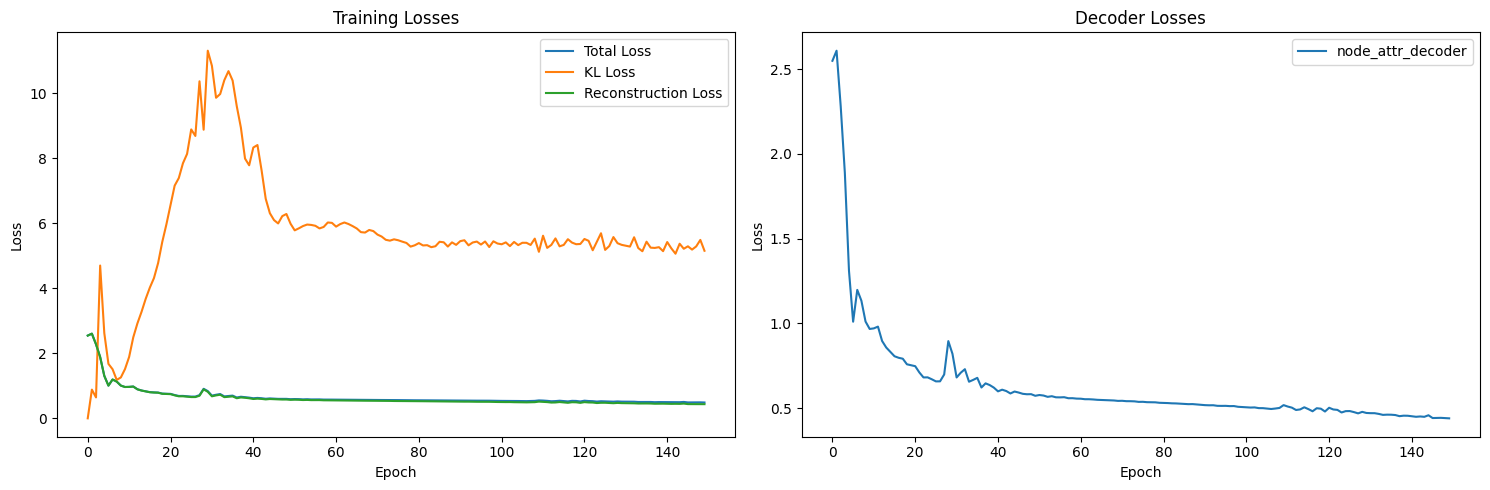

Adjacency decoder not found


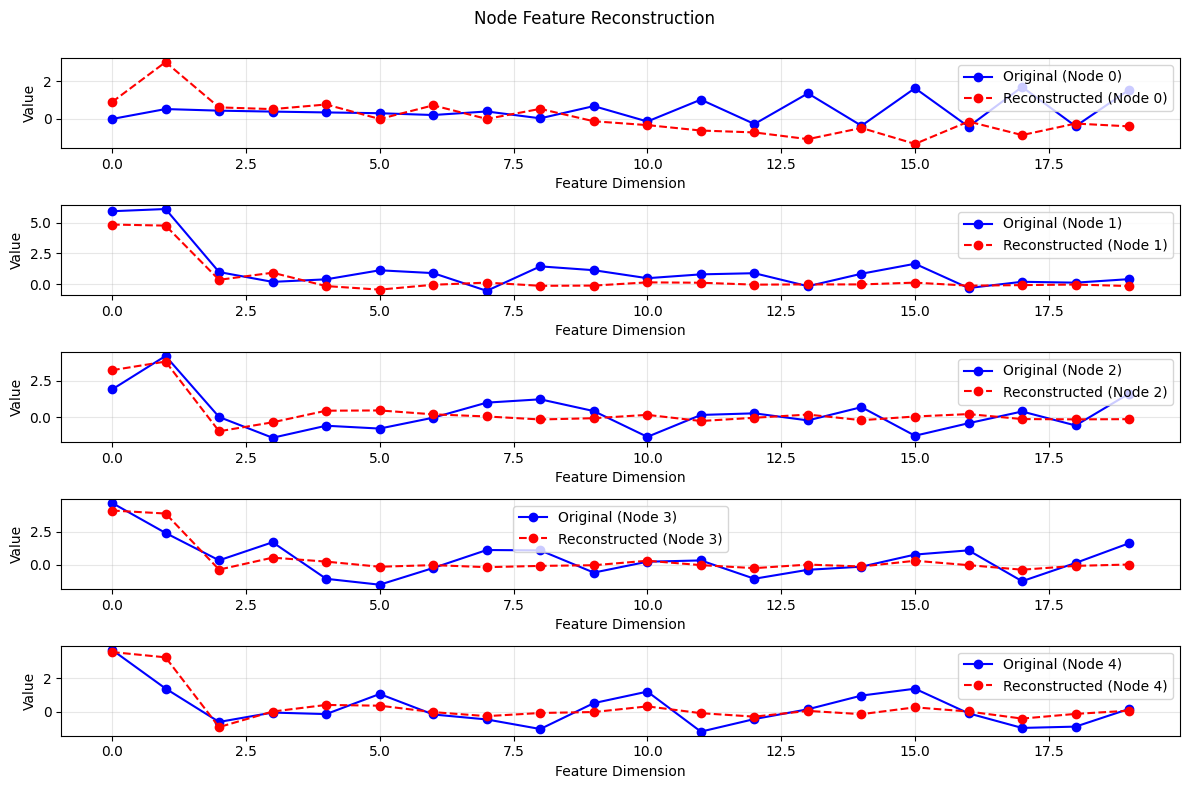

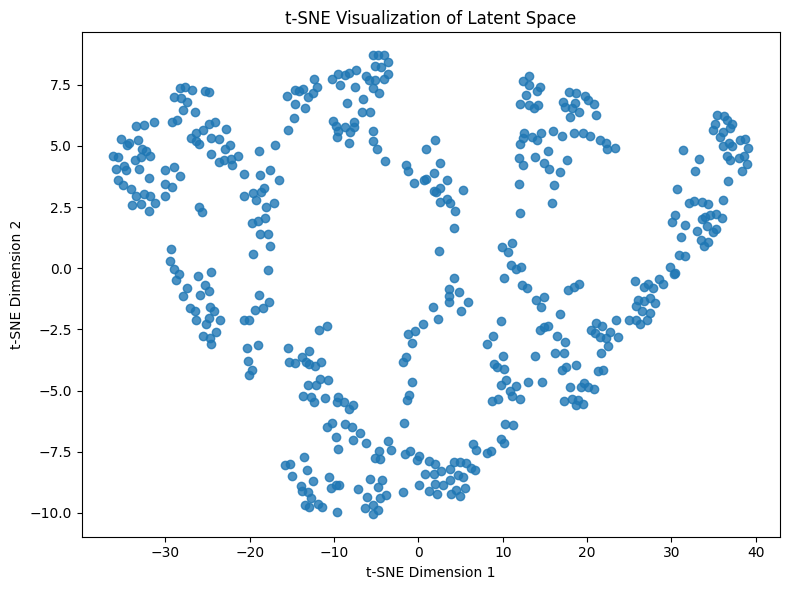

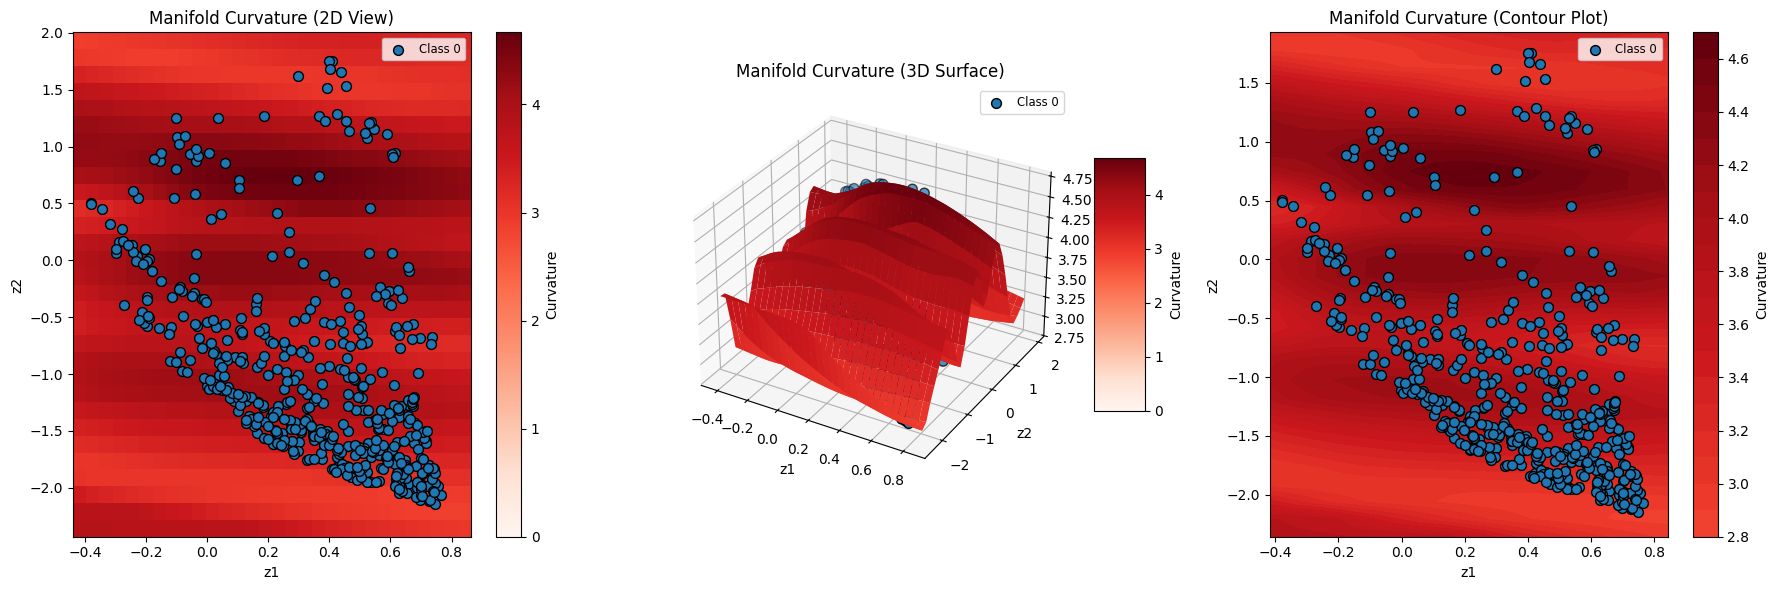

=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===

=== Phase 2 Complete ===


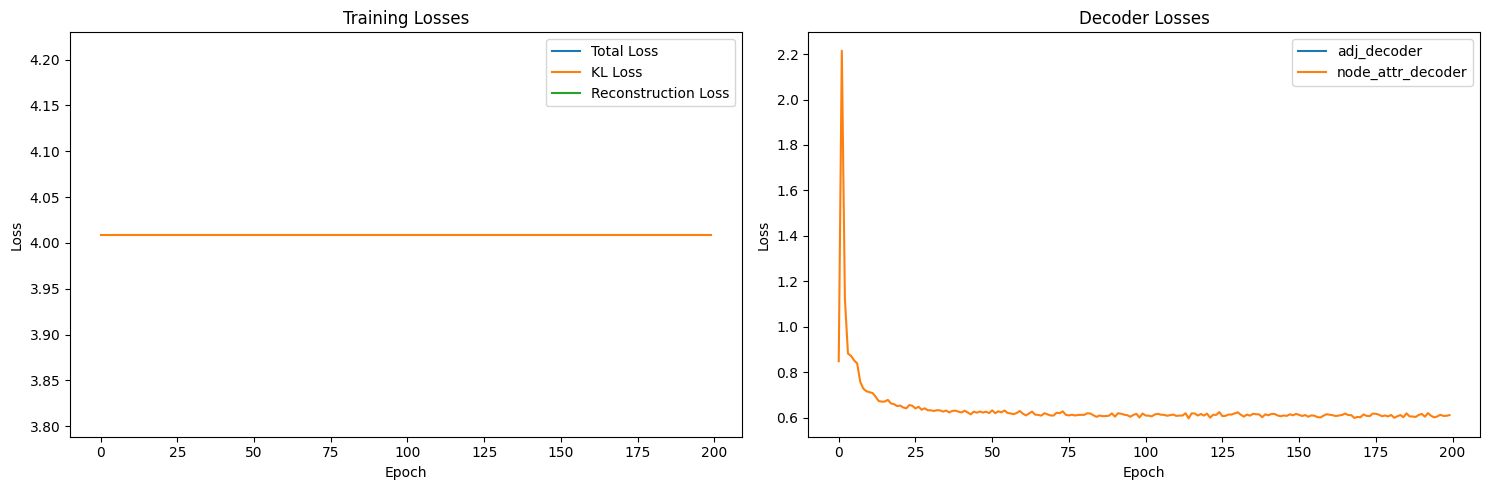

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


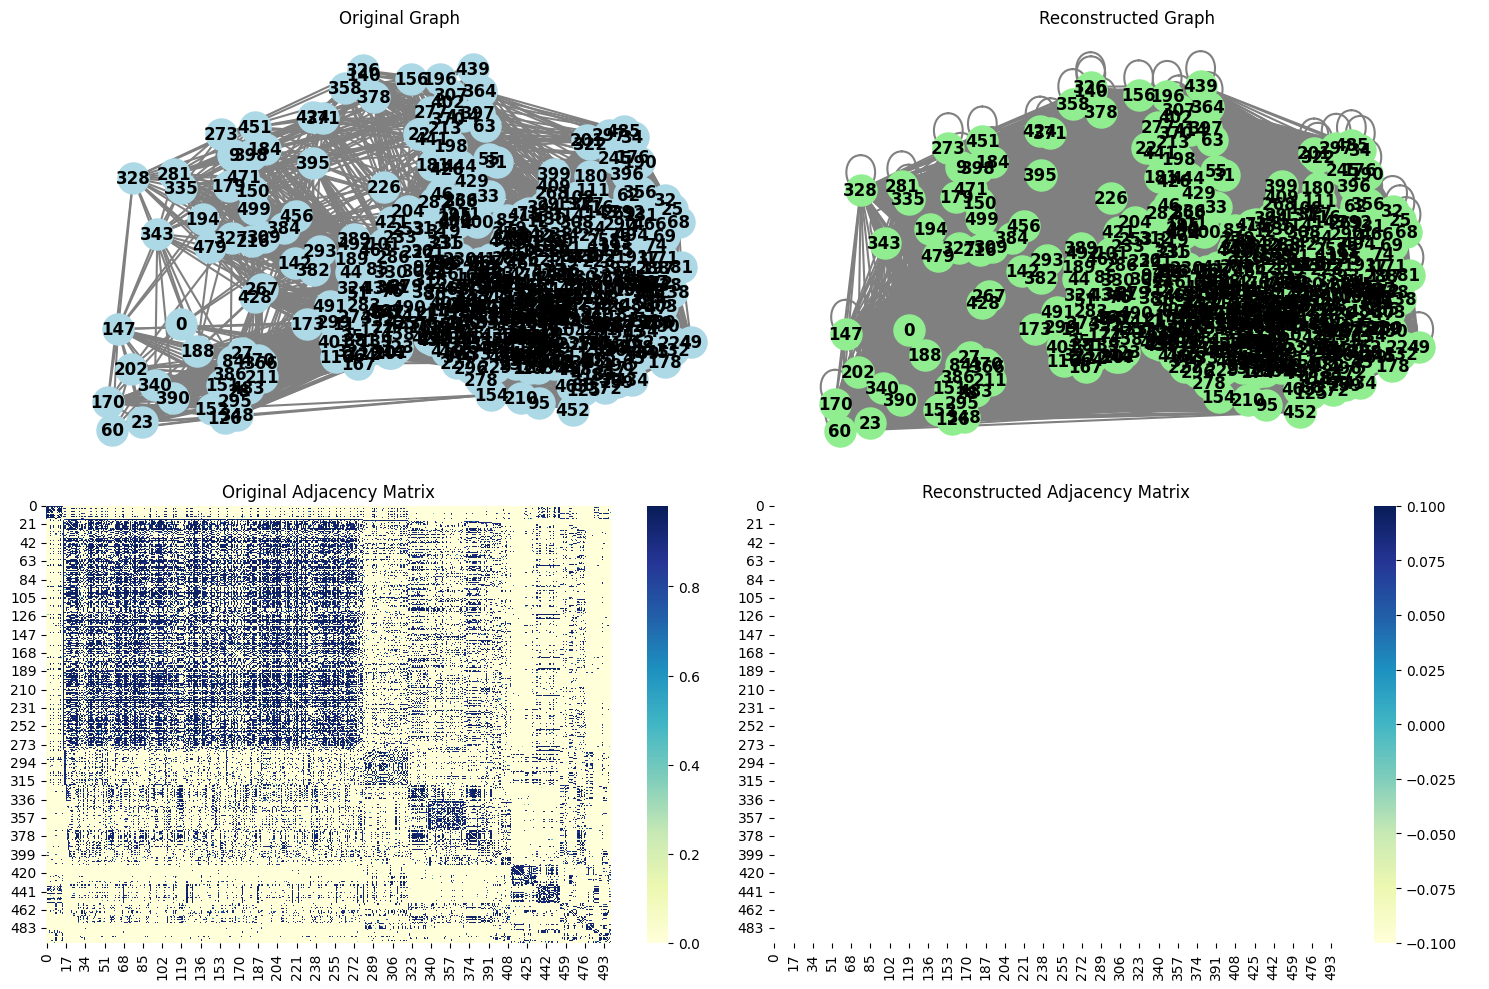

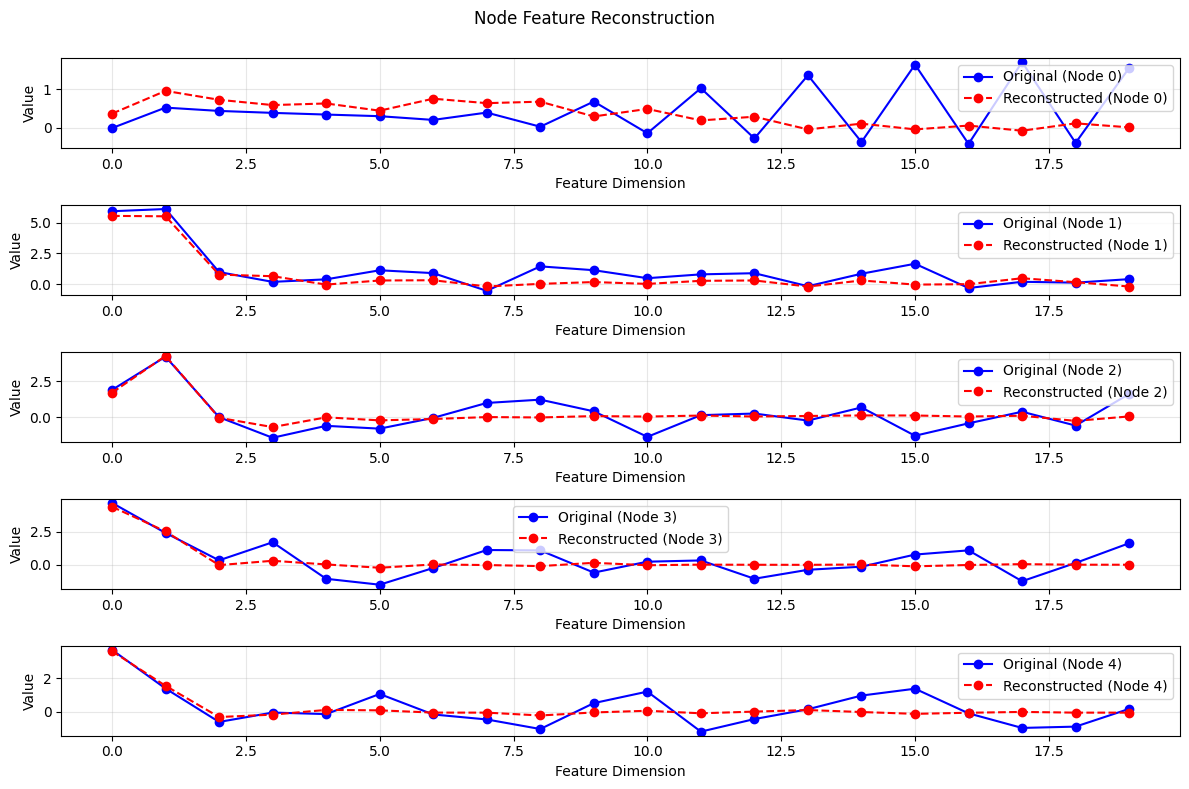

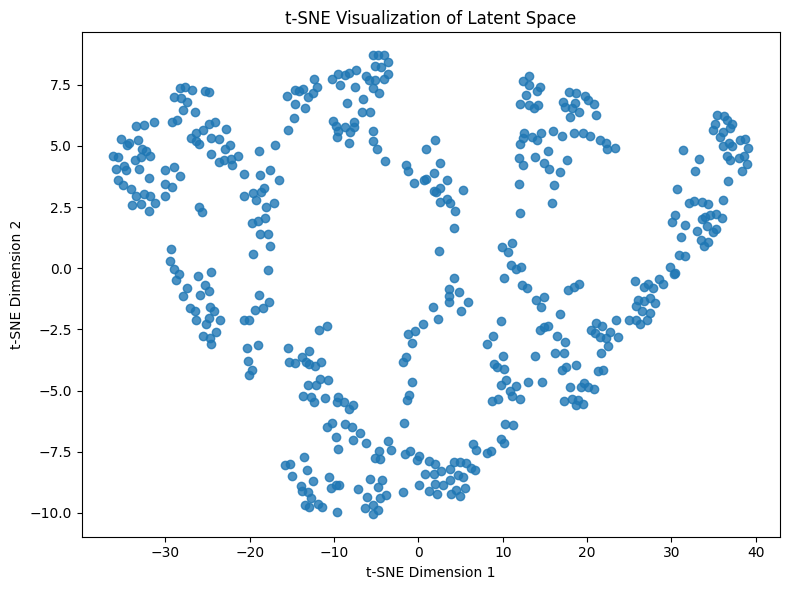

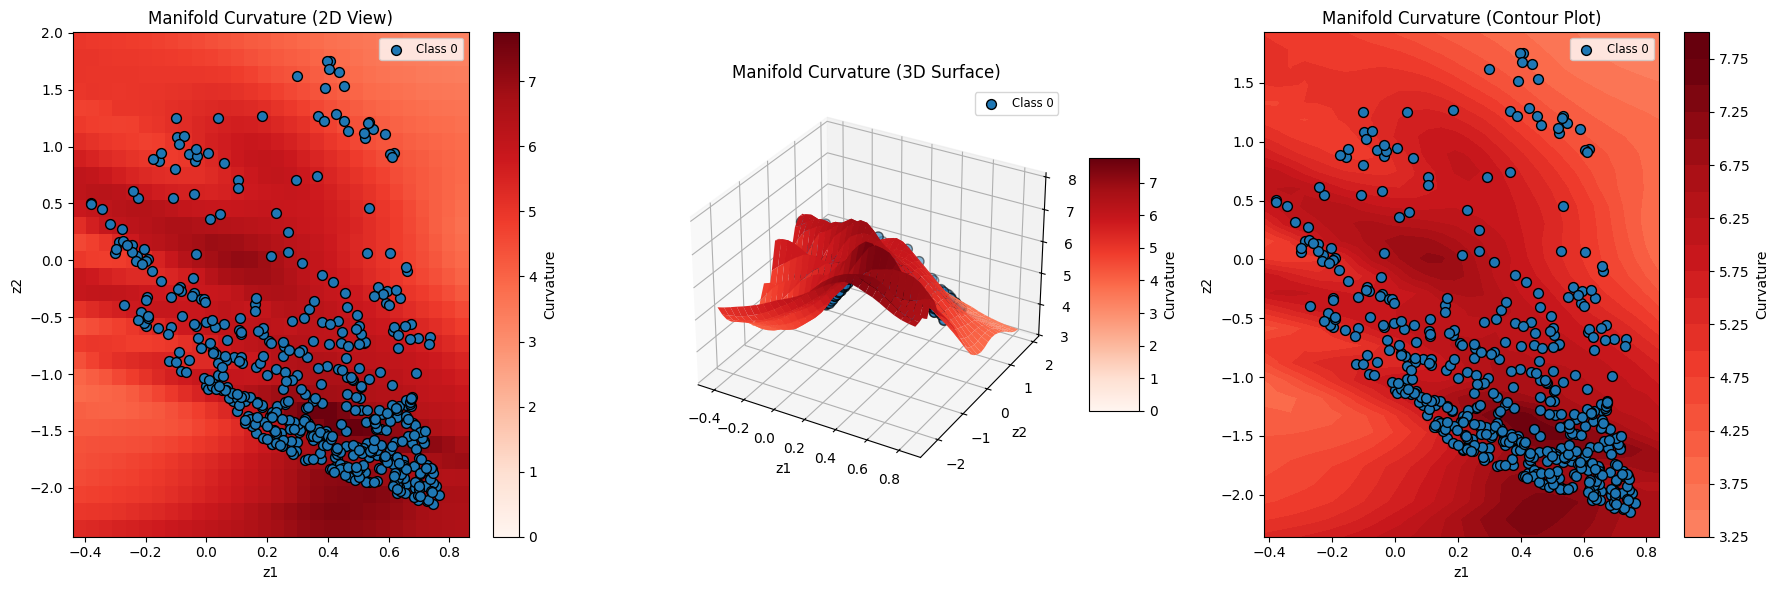

In [7]:
from framework.trainFct import two_phase_training

class SigmoidBinary(nn.Module):
    def __init__(self, threshold: float = 0.5, temperature: float = 0.1):
        super(SigmoidBinary, self).__init__()
        self.threshold = threshold
        self.temperature = temperature
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Center around threshold and scale by temperature
        return torch.sigmoid((x - self.threshold) / self.temperature)
    
dropout = 0
phase1_epochs = 150
phase2_epochs = 200
lr_phase1 = 0.001
lr_phase2 = 0.001
latent_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Run two-phase training
# model, history = two_phase_training(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     data_loader_phase1=single_graph_list,
#     data_loader_phase2=single_graph_list,
#     phase1_epochs=100,
#     phase2_epochs=100,
#     verbose=True
# )

# Step 1: Create encoder and node decoder for phase 1
encoder = Encoder(
    input_dim=input_dim,
    hidden_dims=[5000, 1280,640, 312],
    latent_dim=latent_dim,
    gcn_layers=4,
    fc_layers=2,
    dropout=dropout,
    activation=nn.ELU()
)
# encoder = MLPEncoder(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     hidden_dims=[5000, 1280,640, 320],
#     mlp_layers=3,
#     dropout=dropout
# )

node_decoder = NodeAttributeDecoder(
    latent_dim=latent_dim,
    output_dim=input_dim,
    hidden_dims=[512, 1028, 1028, 512],
    #hidden_dims=[128],
    dropout=dropout,
    activation=nn.ELU(),
    #final_activation=SigmoidBinary(threshold=0.5, temperature=0.1)
)

# Create KL annealing scheduler
kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=0.01,
    anneal_steps=phase1_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Create initial model with only node decoder
model_phase1 = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder],
    kl_scheduler=kl_scheduler
)

print("=== Starting Phase 1: Training encoder with node feature reconstruction ===")

# Phase 1 training
history_phase1 = train_phase1(
    model=model_phase1,
    data_loader=single_graph_list,
    num_epochs=phase1_epochs,
    lr=lr_phase1,
    weight_decay=1e-5,
    verbose=False,
    device=device,
    loss_coefficient=1
)

print("\n=== Phase 1 Complete ===")

visualize_training(history_phase1)
visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase1, single_graph, sample_features=dimP)
visualize_latent_space(model_phase1, [single_graph])
plot_curvature(model_phase1, single_graph)

print("=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===")

# Step 2: Add adjacency decoder for phase 2
adjacency_decoder = AdjacencyDecoder(
    latent_dim=latent_dim,
    hidden_dims=[512, 1028, 1028, 512],
    activation=nn.ELU(),
    dropout=dropout
)

# Add adjacency decoder to model
model_phase1.add_decoder(adjacency_decoder)

# Reset KL scheduler for phase 2
model_phase1.kl_scheduler = KLAnnealingScheduler(
    anneal_start=0,  # Start at midpoint since encoder is already trained
    anneal_end=0.1,
    anneal_steps=phase2_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Phase 2 training
history_phase2 = train_phase2(
    model=model_phase1,
    data_loader=single_graph_list,
    num_epochs=phase2_epochs,
    lr=lr_phase2,
    weight_decay=1e-5,
    decoder_weights={"adjacency_decoder": 1000, "node_decoder":2 },
    verbose=False,
    device=device,
)

print("\n=== Phase 2 Complete ===")
visualize_training(history_phase2)
visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase1, single_graph, sample_features=dimP)
visualize_latent_space(model_phase1, [single_graph])
plot_curvature(model_phase1, single_graph)


# Combine histories
combined_history = {
    "phase1": history_phase1,
    "phase2": history_phase2
}

# Unfreeze encoder for potential further use
model_phase1.set_encoder_freeze(False)


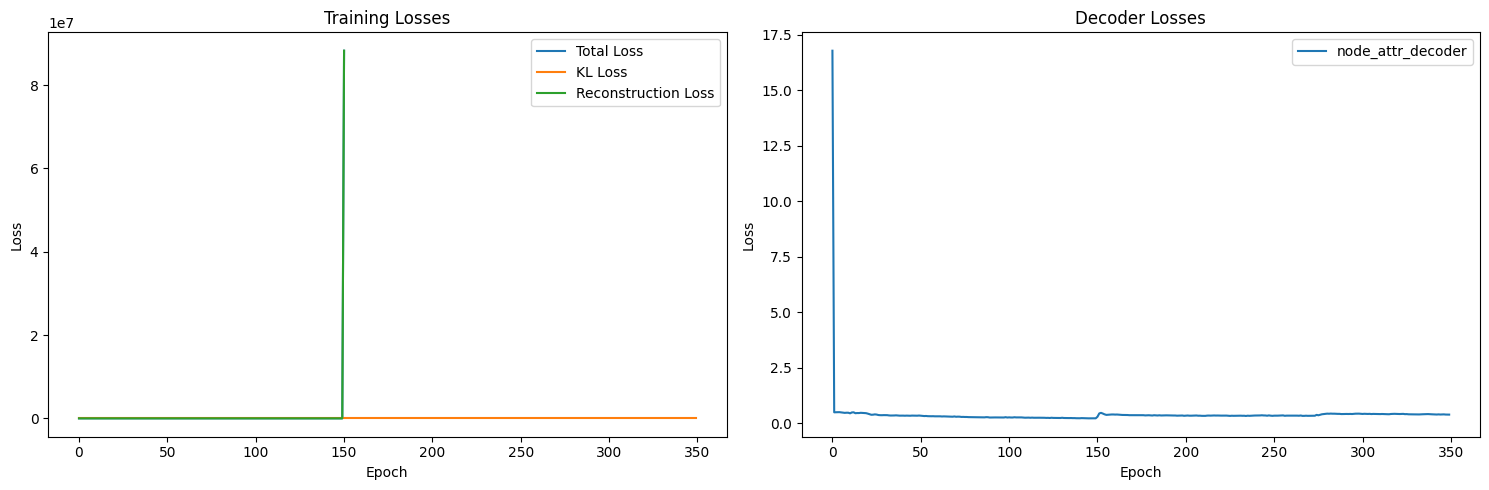

In [12]:
merged_history = {}
for key in history_phase1.keys():
  if isinstance(history_phase1[key], list):
    merged_history[key] = history_phase1[key] + history_phase2[key]
  else:
     merged_history[key] = dict()
     for key2 in history_phase1[key].keys():
        merged_history[key][key2] = history_phase1[key][key2] + history_phase2[key][key2]

visualize_training(merged_history)



Generated 500 wavy surface vectors in R^20:
[[-4.13493899e-03  5.26581611e-01  4.40725321e-01  3.90151097e-01
   3.46353385e-01  3.03977389e-01  2.07384068e-01  3.97534215e-01
   3.09403664e-02  6.84138425e-01 -1.38518002e-01  1.02990580e+00
  -2.72856131e-01  1.36553078e+00 -3.65888874e-01  1.64210536e+00
  -4.14961678e-01  1.70752714e+00 -3.88394694e-01  1.55665779e+00]
 [ 5.92871665e+00  6.10830107e+00  9.81160662e-01  1.83333670e-01
   3.89649018e-01  1.12534696e+00  8.95481249e-01 -5.46199434e-01
   1.44326176e+00  1.13179867e+00  4.82077912e-01  7.93457645e-01
   8.88193752e-01 -1.69955197e-01  8.44770450e-01  1.65585258e+00
  -3.16698580e-01  1.90152067e-01  1.18911534e-01  4.05480245e-01]
 [ 1.90170186e+00  4.21350177e+00  5.96089370e-03 -1.42621292e+00
  -5.96304186e-01 -7.91777017e-01 -4.18159413e-02  9.95689446e-01
   1.22473035e+00  4.13191307e-01 -1.36305822e+00  1.46538805e-01
   2.58978793e-01 -2.28580478e-01  6.83960261e-01 -1.28626627e+00
  -4.22803672e-01  3.85483194e

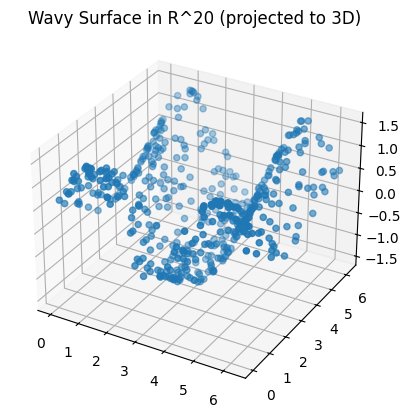

In [4]:
import numpy as np

def generate_n_dim_vectors(num_points, n_dimensions, mapping_function, u_range=(0.0, 1.0), v_range=(0.0, 1.0)):
    """
    Generates n-dimensional vectors that lie on a 2D manifold.

    The 2D manifold is defined by a 'mapping_function' f(u, v) -> R^n.
    This function generates 'num_points' by sampling 'u' and 'v' uniformly
    from their respective ranges and applying the mapping function.

    Args:
        num_points (int): The number of n-dimensional vectors to generate.
        n_dimensions (int): The dimension (n) of the ambient space (R^n).
                            Must be at least 2.
        mapping_function (callable): A function that defines the 2D manifold.
                                     It must accept three arguments:
                                     - u_coords (1D numpy.ndarray): Array of u-coordinates.
                                     - v_coords (1D numpy.ndarray): Array of v-coordinates.
                                     - n_dimensions (int): The target ambient dimension.
                                     It must return a numpy.ndarray of shape
                                     (num_points, n_dimensions).
        u_range (tuple, optional): A tuple (min_u, max_u) defining the range
                                   for the 'u' parameter. Defaults to (0.0, 1.0).
        v_range (tuple, optional): A tuple (min_v, max_v) defining the range
                                   for the 'v' parameter. Defaults to (0.0, 1.0).

    Returns:
        numpy.ndarray: An array of shape (num_points, n_dimensions)
                       containing the generated n-dimensional vectors.

    Raises:
        ValueError: If n_dimensions is less than 2, or if the mapping function
                    returns an array of the wrong shape.
    """
    if n_dimensions < 2:
        raise ValueError("n_dimensions must be at least 2 to embed a 2D manifold.")

    # Generate random u and v coordinates within the specified ranges
    u_coords = np.random.uniform(u_range[0], u_range[1], num_points)
    v_coords = np.random.uniform(v_range[0], v_range[1], num_points)

    # Apply the mapping function to get the n-dimensional vectors
    n_dim_vectors = mapping_function(u_coords, v_coords, n_dimensions)

    # Validate the output shape of the mapping function
    if n_dim_vectors.shape != (num_points, n_dimensions):
        raise ValueError(
            f"Mapping function must return an array of shape ({num_points}, {n_dimensions}). "
            f"Got {n_dim_vectors.shape} instead."
        )

    return n_dim_vectors

# --- Example Mapping Functions to define different 2D Manifolds ---

def planar_patch_mapping(u_coords, v_coords, n_dimensions):
    """
    Defines a simple planar patch embedded in R^n.
    The first two dimensions are directly mapped to u and v,
    and higher dimensions are linear combinations or zeros.
    """
    num_points = len(u_coords)
    vectors = np.zeros((num_points, n_dimensions))

    # Define two linearly independent direction vectors in R^n for the plane
    # For a simple and deterministic example:
    dir1 = np.zeros(n_dimensions)
    dir1[0] = 1.0  # u-axis direction
    if n_dimensions > 2:
        dir1[2] = 0.5 # Adds a slight tilt in the 3rd dimension

    dir2 = np.zeros(n_dimensions)
    dir2[1] = 1.0  # v-axis direction
    if n_dimensions > 3:
        dir2[3] = -0.3 # Adds a slight tilt in the 4th dimension

    # An origin point for the plane (can be np.zeros(n_dimensions))
    origin = np.full(n_dimensions, 0.1) # Slightly offset from origin for illustration

    for i in range(num_points):
        vectors[i, :] = origin + u_coords[i] * dir1 + v_coords[i] * dir2
    return vectors

def wavy_surface_mapping(u_coords, v_coords, n_dimensions):
    """
    Defines a wavy, non-linear surface embedded in R^n.
    The first two dimensions are u and v, and subsequent dimensions
    are determined by trigonometric functions of u and v.
    """
    num_points = len(u_coords)
    vectors = np.zeros((num_points, n_dimensions))

    vectors[:, 0] = u_coords  # First dimension is u
    vectors[:, 1] = v_coords  # Second dimension is v

    # Define the remaining dimensions based on u and v to create curvature
    for i in range(2, n_dimensions):
        if i % 2 == 0:
            vectors[:, i] = np.sin(u_coords * (i + 1) / 2) + np.cos(v_coords * (i + 1) / 3) * 0.5
        else:
            vectors[:, i] = np.cos(u_coords * (i + 1) / 3) - np.sin(v_coords * (i + 1) / 2) * 0.7
    return vectors

def sphere_like_mapping(u_coords, v_coords, n_dimensions, radius=1.0):
    """
    Generates points on a sphere-like surface, suitable for R^n where n >= 3.
    u_coords and v_coords are typically angles (e.g., from 0 to 2*pi).
    For n=3, it creates a standard sphere. For n > 3, it projects the sphere
    onto the first 3 dimensions and adds higher dimensions.
    """
    num_points = len(u_coords)
    vectors = np.zeros((num_points, n_dimensions))

    if n_dimensions < 3:
        raise ValueError("n_dimensions must be at least 3 for a sphere-like manifold.")

    # Standard spherical coordinates mapping to R^3
    # u_coords (theta) typically 0 to pi, v_coords (phi) typically 0 to 2*pi
    # Adjust ranges in generate_n_dim_vectors for correct sampling
    x = radius * np.sin(u_coords) * np.cos(v_coords)
    y = radius * np.sin(u_coords) * np.sin(v_coords)
    z = radius * np.cos(u_coords)

    vectors[:, 0] = x
    vectors[:, 1] = y
    vectors[:, 2] = z

    # For n > 3, define the remaining dimensions
    # These dimensions are still functions of u and v, ensuring it's a 2D manifold
    for i in range(3, n_dimensions):
        vectors[:, i] = np.sin(u_coords * (i - 1)) * np.cos(v_coords * i) * 0.2
    return vectors

def add_noise(vectors, noise_level=0.01):
    """
    Adds isotropic Gaussian noise to each point in the dataset.
    
    Args:
        vectors (numpy.ndarray): Array of shape (num_points, n_dimensions).
        noise_level (float): Standard deviation of Gaussian noise.
    
    Returns:
        numpy.ndarray: Noisy data.
    """
    noise = np.random.normal(0, noise_level, vectors.shape)
    return vectors + noise

# Example 2: Generate points on a wavy surface in R^5
num_points_wavy = 500
n_dim_wavy = 20
wavy_vectors = add_noise(generate_n_dim_vectors(
    num_points_wavy,
    n_dim_wavy,
    wavy_surface_mapping,
    u_range=(0.0, 2 * np.pi),
    v_range=(0.0, 2 * np.pi)
))
print(f"Generated {num_points_wavy} wavy surface vectors in R^{n_dim_wavy}:")
print(wavy_vectors[:5])
print(f"Shape: {wavy_vectors.shape}\n")

# To visualize (e.g., for n=3):
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(wavy_vectors[:,0], wavy_vectors[:,1], wavy_vectors[:,2])
ax.set_title(f'Wavy Surface in R^{n_dim_wavy} (projected to 3D)')
plt.show()



wavydata = Data(x=torch.tensor(wavy_vectors, dtype=torch.float), 
                edge_index=create_full_loops_edge_index(num_points_wavy),
                edge_labels=torch.tensor(np.ones_like(create_full_loops_edge_index(num_points_wavy))))




In [5]:
np.savetxt("wavy_comp_matrix.csv", np.dot(wavy_vectors, np.transpose(wavy_vectors)), fmt='%.6f', delimiter=',')
np.savetxt("wavy_p_matrix.csv", wavy_vectors, fmt='%.6f', delimiter=',')

=== Starting Phase 1: Training encoder with node feature reconstruction ===

=== Phase 1 Complete ===


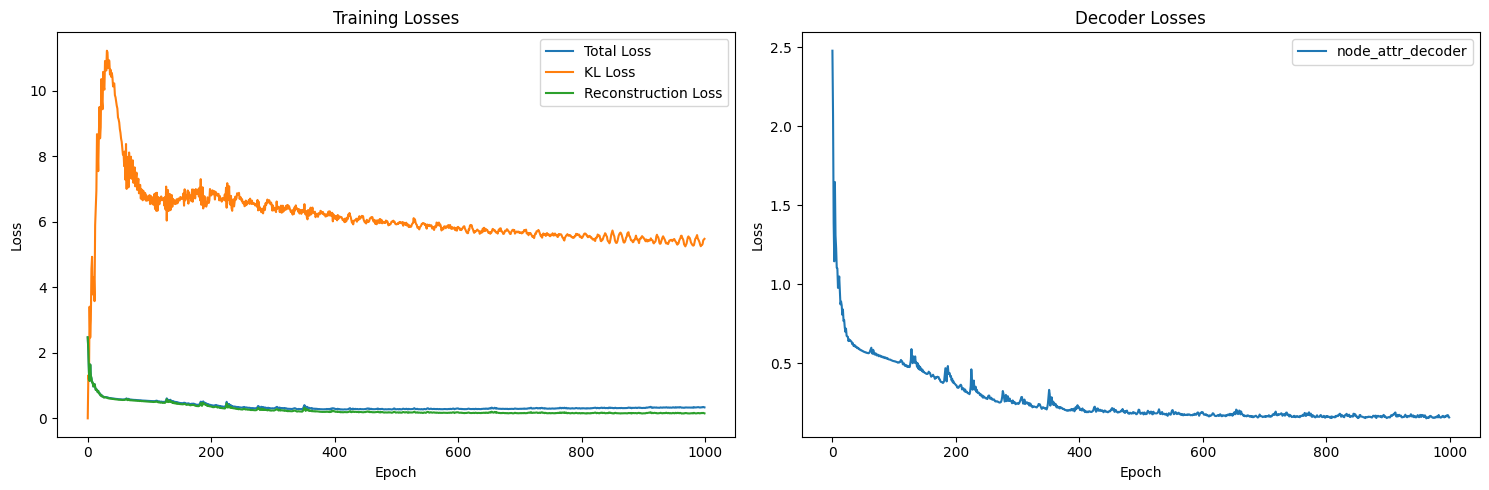

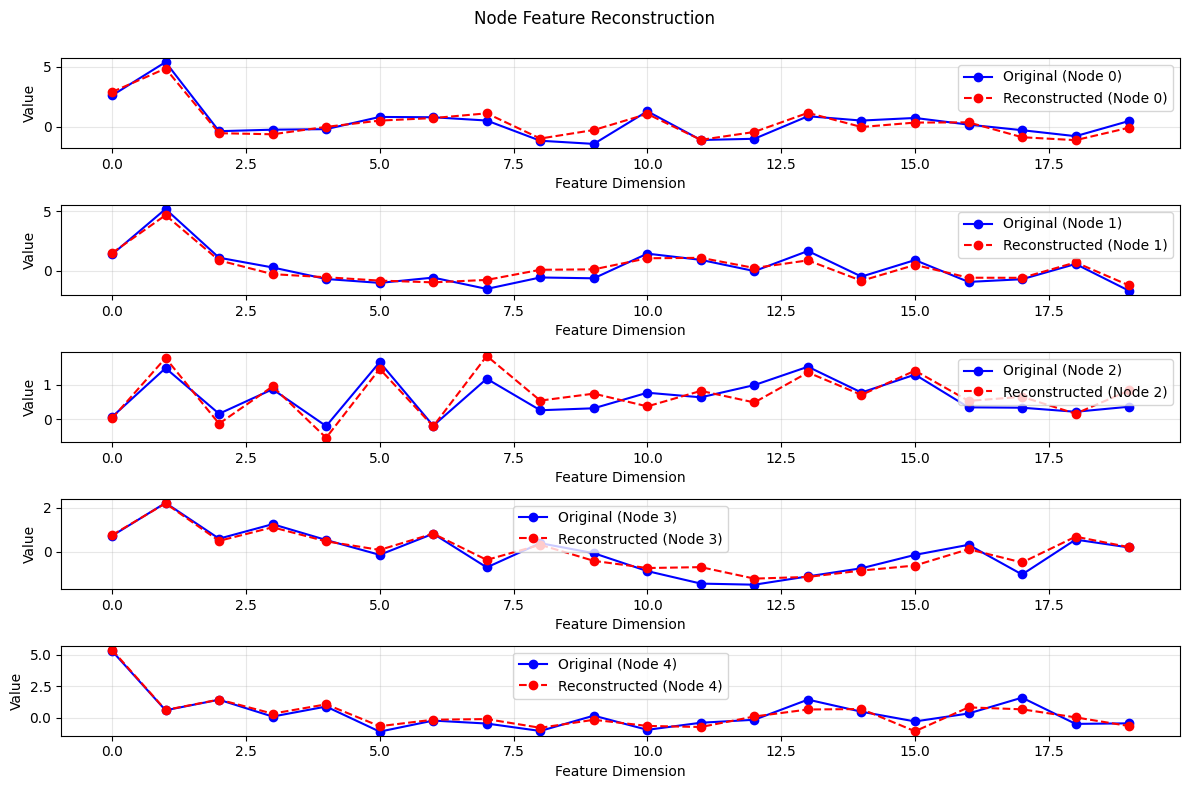

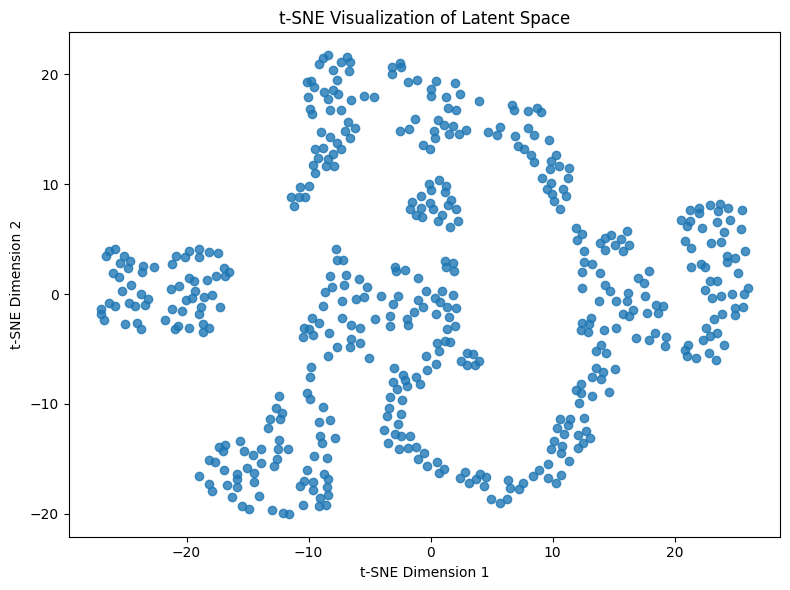

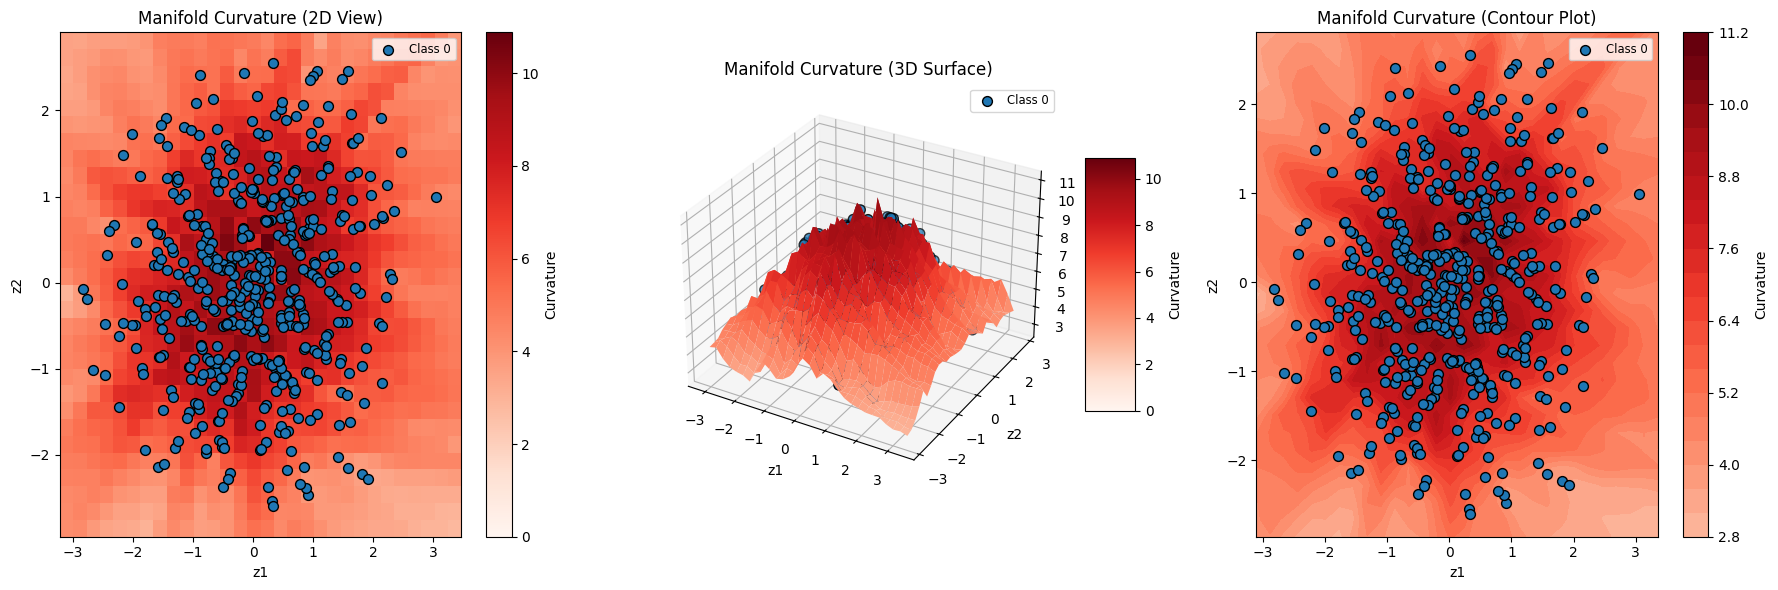

In [18]:
from framework.trainFct import two_phase_training

dropout = 0
phase1_epochs = 1000
phase2_epochs = 2000
lr_phase1 = 0.001
lr_phase2 = 0.0001
latent_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Run two-phase training
# model, history = two_phase_training(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     data_loader_phase1=single_graph_list,
#     data_loader_phase2=single_graph_list,
#     phase1_epochs=100,
#     phase2_epochs=100,
#     verbose=True
# )

# Step 1: Create encoder and node decoder for phase 1
encoder = Encoder(
    input_dim=20,
    hidden_dims=[5000, 1280,640, 312],
    latent_dim=latent_dim,
    gcn_layers=4,
    fc_layers=2,
    activation=nn.ELU(),
    dropout=dropout
)
# encoder = MLPEncoder(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     hidden_dims=[5000, 1280,640, 320],
#     mlp_layers=3,
#     dropout=dropout
# )

node_decoder = NodeAttributeDecoder(
    latent_dim=latent_dim,
    output_dim=20,
    hidden_dims=[512, 1028, 1028, 512],
    #hidden_dims=[128],
    activation=nn.ELU(),
    dropout=dropout
)

# Create KL annealing scheduler
kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=0.1,
    anneal_steps=phase1_epochs * len(wavydata),
    anneal_type='linear'
)

# Create initial model with only node decoder
model_phase1 = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder],
    kl_scheduler=kl_scheduler
)

print("=== Starting Phase 1: Training encoder with node feature reconstruction ===")

# Phase 1 training
history_phase1 = train_phase1(
    model=model_phase1,
    data_loader=[wavydata],
    num_epochs=phase1_epochs,
    lr=lr_phase1,
    weight_decay=1e-5,
    verbose=False,
    device=device,
    loss_coefficient=1
)

print("\n=== Phase 1 Complete ===")

visualize_training(history_phase1)
visualize_node_features_reconstruction(model_phase1, wavydata, sample_features=20)
visualize_latent_space(model_phase1, [wavydata])
plot_curvature(model_phase1, wavydata)
